In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Redimensionnement des images:**

In [2]:
import cv2
import os
import shutil

# Chemins
image_folder = "/content/drive/MyDrive/datadata/Images"
label_folder = "/content/drive/MyDrive/datadata/Labels"
output_image_folder = "/content/drive/MyDrive/datadata/Images1"
output_label_folder = "/content/drive/MyDrive/datadata/Labels1"

# Dimensions cibles
target_width, target_height = 640, 640

# Création des dossiers de sortie
os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_label_folder, exist_ok=True)

# Traitement des images et annotations
for file_name in os.listdir(image_folder):
    # Chemin de l'image et de l'annotation correspondante
    img_path = os.path.join(image_folder, file_name)
    label_path = os.path.join(label_folder, file_name.replace('.jpg', '.txt'))

    # Vérification des fichiers
    if not os.path.exists(label_path):
        print(f"Annotation manquante pour : {file_name}")
        continue

    # Charger l'image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Impossible de lire l'image : {file_name}")
        continue

    # Dimensions originales
    original_height, original_width = img.shape[:2]

    # Redimensionner l'image
    resized_img = cv2.resize(img, (target_width, target_height))
    cv2.imwrite(os.path.join(output_image_folder, file_name), resized_img)

    # Mettre à jour les labels (pas nécessaire si déjà normalisés)
    with open(label_path, "r") as f:
        lines = f.readlines()

    updated_labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = parts[0]
        x_center, y_center, width, height = map(float, parts[1:])

        # Normalisation : rien à changer car les labels YOLO utilisent un format relatif
        updated_labels.append(f"{class_id} {x_center} {y_center} {width} {height}")

    # Sauvegarder les annotations mises à jour
    with open(os.path.join(output_label_folder, file_name.replace('.jpg', '.txt')), "w") as f:
        f.write("\n".join(updated_labels))

print("Redimensionnement des images et ajustement des labels terminé.")



Redimensionnement des images et ajustement des labels terminé.


# **Data augmentation**

In [3]:
import albumentations as A
from albumentations import HorizontalFlip, RandomBrightnessContrast, GaussianBlur
import cv2
import os

# Transformation d'augmentation
augmentation = A.Compose([
    HorizontalFlip(p=0.5),  # Inverse horizontalement
    RandomBrightnessContrast(p=0.2),  # Contraste et luminosité
    GaussianBlur(p=0.1)  # Flou gaussien
], bbox_params=A.BboxParams(format="yolo", label_fields=["class_labels"]))

# Chemins des dossiers
input_folder = "/content/drive/MyDrive/datadata/Images1"
label_folder = "/content/drive/MyDrive/datadata/Labels1"
output_image_folder = "/content/drive/MyDrive/datadata/Images1"
output_label_folder = "/content/drive/MyDrive/datadata/Labels1"
os.makedirs(output_image_folder, exist_ok=True)
os.makedirs(output_label_folder, exist_ok=True)

# Nombre d'augmentations par image
num_augmentations = 3

# Extensions d'image valides
valid_extensions = {".jpg", ".jpeg", ".png"}

# Appliquer l'augmentation
for file_name in os.listdir(input_folder):
    if not any(file_name.lower().endswith(ext) for ext in valid_extensions):
        print(f"Fichier ignoré (non image) : {file_name}")
        continue

    # Chemin de l'image et de l'annotation
    img_path = os.path.join(input_folder, file_name)
    label_path = os.path.join(label_folder, file_name.replace(".jpg", ".txt"))

    # Charger l'image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Impossible de lire l'image : {file_name}")
        continue

    # Charger les labels
    if not os.path.exists(label_path):
        print(f"Annotation manquante pour : {file_name}")
        continue

    with open(label_path, "r") as f:
        lines = f.readlines()

    # Préparer les annotations pour Albumentations
    bboxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        class_id = parts[0]
        bbox = list(map(float, parts[1:]))
        bboxes.append(bbox)
        class_labels.append(class_id)

    # Appliquer plusieurs augmentations
    for i in range(num_augmentations):
        try:
            augmented = augmentation(image=img, bboxes=bboxes, class_labels=class_labels)
            augmented_img = augmented["image"]
            augmented_bboxes = augmented["bboxes"]
            augmented_class_labels = augmented["class_labels"]
        except Exception as e:
            print(f"Erreur lors de l'augmentation pour {file_name} (augmentation {i+1}) : {e}")
            continue

        # Enregistrer l'image augmentée
        new_file_name = f"aug_{i+1}_{file_name}"
        cv2.imwrite(os.path.join(output_image_folder, new_file_name), augmented_img)

        # Enregistrer les annotations augmentées
        new_label_path = os.path.join(output_label_folder, new_file_name.replace(".jpg", ".txt"))
        with open(new_label_path, "w") as f:
            for bbox, class_id in zip(augmented_bboxes, augmented_class_labels):
                bbox_str = " ".join(map(str, bbox))
                f.write(f"{class_id} {bbox_str}\n")

print("Data augmentation avec plusieurs augmentations par image terminée.")



/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Data augmentation avec plusieurs augmentations par image terminée.


In [4]:
import os

# Chemin vers le dossier des images augmentées
output_image_folder = "/content/drive/MyDrive/datadata/Images1"

# Compter le nombre de fichiers dans le dossier des images augmentées
augmented_image_count = len([f for f in os.listdir(output_image_folder) if f.endswith(('.jpg', '.png', '.jpeg'))])

print(f"Nombre total d'images après augmentation : {augmented_image_count}")


Nombre total d'images après augmentation : 1736


In [5]:
from sklearn.model_selection import train_test_split
import shutil

# Dossiers
image_folder = "/content/drive/MyDrive/datadata/Images1"
label_folder = "/content/drive/MyDrive/datadata/Labels1"
output_dir = "/content/drive/MyDrive/datadata/dataset_split"

# Crée les dossiers pour chaque split
splits = ['train', 'valid', 'test']
for split in splits:
    os.makedirs(os.path.join(output_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, split, 'labels'), exist_ok=True)

# Liste des fichiers
image_files = sorted(os.listdir(image_folder))
label_files = sorted(os.listdir(label_folder))

# Vérification : correspondance des fichiers
assert len(image_files) == len(label_files), "Nombre d'images et annotations différent"
for img, label in zip(image_files, label_files):
    assert img.split('.')[0] == label.split('.')[0], f"Incohérence : {img}, {label}"

# Diviser les données
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    image_files, label_files, test_size=0.3, random_state=42
)
valid_imgs, test_imgs, valid_labels, test_labels = train_test_split(
    test_imgs, test_labels, test_size=0.33, random_state=42
)

# Copier les fichiers
def copy_files(files, src_folder, dest_folder):
    for file_name in files:
        shutil.copy(os.path.join(src_folder, file_name), os.path.join(dest_folder, file_name))

copy_files(train_imgs, image_folder, os.path.join(output_dir, 'train/images'))
copy_files(train_labels, label_folder, os.path.join(output_dir, 'train/labels'))

copy_files(valid_imgs, image_folder, os.path.join(output_dir, 'valid/images'))
copy_files(valid_labels, label_folder, os.path.join(output_dir, 'valid/labels'))

copy_files(test_imgs, image_folder, os.path.join(output_dir, 'test/images'))
copy_files(test_labels, label_folder, os.path.join(output_dir, 'test/labels'))

print("Division terminée avec succès.")


Division terminée avec succès.


In [6]:
import os

# Dossiers des annotations pour train, test et valid
base_path = "/content/drive/MyDrive/datadata/dataset_split"
folders = ["train/labels", "test/labels", "valid/labels"]

# Mappage des classes
class_mapping = {
    15: 0,
    16: 1,
    17: 2,
    18: 3,
    19: 4,
    20: 5,
    21: 6,
}

# Fonction pour corriger les annotations
def correct_annotations(annotation_folder):
    for file_name in os.listdir(annotation_folder):
        file_path = os.path.join(annotation_folder, file_name)

        with open(file_path, "r") as f:
            lines = f.readlines()

        corrected_lines = []
        for line in lines:
            parts = line.strip().split()
            original_class = int(parts[0])

            # Vérifier si la classe est dans le mappage
            if original_class in class_mapping:
                corrected_class = class_mapping[original_class]
                corrected_line = f"{corrected_class} {' '.join(parts[1:])}\n"
                corrected_lines.append(corrected_line)
            else:
                print(f"Classe non reconnue dans {file_name}: {original_class}")

        # Écrire les annotations corrigées
        with open(file_path, "w") as f:
            f.writelines(corrected_lines)

# Parcourir les dossiers et appliquer la correction
for folder in folders:
    annotation_folder = os.path.join(base_path, folder)
    print(f"Correction des annotations pour : {annotation_folder}")
    correct_annotations(annotation_folder)

print("Correction des annotations terminée pour tous les dossiers.")



Correction des annotations pour : /content/drive/MyDrive/datadata/dataset_split/train/labels
Correction des annotations pour : /content/drive/MyDrive/datadata/dataset_split/test/labels
Correction des annotations pour : /content/drive/MyDrive/datadata/dataset_split/valid/labels
Correction des annotations terminée pour tous les dossiers.


In [7]:
yaml_content = """
train: /content/drive/MyDrive/datadata/dataset_split/train/images
val: /content/drive/MyDrive/datadata/dataset_split/valid/images
test: /content/drive/MyDrive/datadata/dataset_split/test/images

# Nombre de classes
nc: 4

# Noms des classes
names: ["Plastic", "Glass","Carton",  "Can"]
"""

# Enregistrer le fichier
yaml_path = "/content/drive/MyDrive/datadata/dataset.yaml"
with open(yaml_path, "w") as file:
    file.write(yaml_content)

print(f"Fichier YAML créé : {yaml_path}")


Fichier YAML créé : /content/drive/MyDrive/datadata/dataset.yaml


In [8]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 15.6 MB/s eta 0:00:00


In [9]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt") # Charger le modèle pré-entraîné YOLOv8
model.train(data=yaml_path, epochs=100, imgsz=640)  # Ajuster les paramètres selon les besoins



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 131M/131M [00:00<00:00, 281MB/s]


Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/drive/MyDrive/datadata/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 15.2MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 65.5MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/datadata/dataset_split/train/labels... 1215 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1215/1215 [00:17<00:00, 67.73it/s] 


train: New cache created: /content/drive/MyDrive/datadata/dataset_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/datadata/dataset_split/valid/labels... 349 images, 0 backgrounds, 0 corrupt: 100%|██████████| 349/349 [00:06<00:00, 54.57it/s] 


val: New cache created: /content/drive/MyDrive/datadata/dataset_split/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.3G      1.304      2.287      1.753         55        640: 100%|██████████| 76/76 [01:37<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]

                   all        349        530     0.0493      0.363      0.031     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      13.2G      1.695      2.414      2.025         50        640: 100%|██████████| 76/76 [01:36<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530     0.0396     0.0254     0.0125    0.00397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.4G      1.733      2.354      2.019         64        640: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.04s/it]

                   all        349        530     0.0413     0.0314     0.0133    0.00519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      13.4G      1.571       2.18      1.912         34        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.387      0.149      0.122     0.0656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      13.4G      1.505      2.059      1.859         49        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.705      0.257      0.217      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      13.4G      1.403      1.942       1.79         39        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530       0.82       0.18      0.278      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.4G      1.394      1.919      1.776         33        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.639      0.521      0.518      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      13.4G      1.363       1.85      1.722         45        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.758      0.413      0.482       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.4G      1.304      1.788      1.696         44        640: 100%|██████████| 76/76 [01:35<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.764      0.445      0.542      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.4G      1.265       1.69      1.675         29        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.788      0.362      0.488      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.4G      1.225      1.658       1.65         41        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.841      0.544       0.63      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.4G      1.236      1.639      1.649         55        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.817       0.44      0.568      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.4G      1.226      1.648      1.653         43        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.647      0.518      0.614      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      13.4G      1.181      1.559        1.6         37        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.716      0.567      0.644      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      13.4G      1.168       1.52       1.59         41        640: 100%|██████████| 76/76 [01:35<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.524      0.594      0.613      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      13.4G      1.153      1.481      1.577         49        640: 100%|██████████| 76/76 [01:35<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530       0.82      0.556       0.65      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      13.4G      1.124      1.451      1.551         45        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.681      0.623      0.679      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.4G      1.148      1.493      1.583         35        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.565      0.634      0.632      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.4G       1.11      1.386       1.54         29        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.601      0.574      0.617      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.4G      1.082      1.358      1.523         32        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.745      0.573      0.696      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.4G      1.072      1.341      1.515         49        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.707      0.653       0.71      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.4G      1.087      1.354      1.519         40        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.749      0.611      0.704      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.4G      1.074      1.304      1.505         32        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.688      0.706      0.753      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      13.4G      1.063      1.267      1.502         42        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.886      0.565      0.702      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      13.4G      1.057      1.268      1.494         50        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.669      0.639      0.713      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.4G      1.018      1.254      1.476         39        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.712      0.667      0.748      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.4G      1.037      1.242       1.48         35        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.894      0.567      0.732      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      13.4G      1.015      1.193      1.467         51        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.659      0.737      0.766      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      13.4G      0.984      1.143      1.438         53        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.729      0.728      0.781      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.4G     0.9865      1.176      1.458         33        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530       0.74       0.69      0.778      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.4G       0.99      1.167      1.456         50        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.795       0.73       0.79      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.4G     0.9855        1.1      1.443         45        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.695      0.742      0.789      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.4G     0.9865      1.141      1.442         47        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.726      0.738       0.79       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.4G     0.9745      1.093      1.435         38        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.793      0.741      0.804      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.4G     0.9494      1.076      1.421         42        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.732      0.741      0.803      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      13.4G     0.9455      1.071      1.408         43        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.797      0.709      0.812      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      13.4G     0.9665      1.068      1.416         43        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.732       0.76      0.803      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      13.4G     0.9326      1.026      1.405         34        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.817      0.681      0.805      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.4G     0.9273      1.004      1.383         43        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530       0.72      0.766      0.791      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.4G     0.9313      1.017      1.386         50        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.808      0.757      0.825      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      13.4G     0.8677     0.9423      1.349         32        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.792      0.795      0.847      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      13.4G     0.8786     0.9777      1.354         48        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.868      0.739       0.84      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.4G       0.91     0.9968      1.383         58        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.833      0.792      0.849       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.4G     0.8936     0.9773      1.372         54        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.762      0.781      0.834      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      13.4G     0.9166     0.9629      1.381         45        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.794        0.8      0.864      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      13.4G     0.8756     0.9572      1.353         40        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.855      0.819      0.876      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      13.4G     0.8766     0.8914      1.334         42        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.819      0.782      0.864      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      13.4G     0.8666     0.9138      1.337         43        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.855      0.817      0.881      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      13.4G     0.8388     0.8734      1.329         46        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.849      0.788      0.873      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.4G     0.8567     0.8952      1.335         45        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.843      0.819      0.883      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      13.4G     0.8174     0.8484      1.315         61        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.857      0.792      0.881      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.4G     0.8261     0.8426       1.31         44        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.871      0.832      0.884      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      13.4G     0.8218     0.8434      1.311         39        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.821      0.857      0.893      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.4G     0.8239     0.8309      1.309         39        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.865      0.843      0.897      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      13.4G     0.8002     0.8144      1.287         37        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.869      0.862      0.914      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      13.4G     0.7979     0.8034      1.295         44        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.865      0.845      0.911       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      13.4G     0.7995     0.7969      1.278         48        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.847      0.893      0.923      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      13.4G     0.7792     0.7668      1.277         39        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.898      0.872      0.927      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      13.4G     0.7737     0.7564      1.271         44        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.887      0.881      0.924      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      13.4G     0.7698     0.7651       1.26         47        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.873      0.872      0.914       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      13.4G      0.755     0.7469      1.259         40        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.891      0.892      0.932       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      13.4G     0.7486     0.7444      1.251         52        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.882      0.898      0.934       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      13.4G     0.7607      0.749      1.257         38        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.912      0.915      0.953      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      13.4G     0.7549      0.733      1.254         32        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.894      0.878       0.93      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.4G      0.733     0.7313      1.242         41        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530       0.94       0.91      0.948      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      13.4G     0.7291     0.7284      1.252         39        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.937       0.89      0.943      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.4G     0.7296     0.7123      1.236         41        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.889      0.888      0.946      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      13.4G     0.7195     0.7003      1.231         45        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.888      0.903      0.943      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      13.4G     0.7173     0.6959       1.23         31        640: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.931      0.895      0.953      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.4G     0.6974     0.6722      1.213         45        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.914      0.912      0.946       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      13.4G     0.6962     0.6646      1.216         37        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.906      0.914      0.952      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.4G     0.6875      0.647      1.211         47        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.917      0.924      0.958      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.4G     0.6937     0.6479      1.216         46        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.933      0.921      0.961      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      13.4G      0.686     0.6409      1.205         57        640: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530       0.92      0.924      0.962       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      13.4G     0.6837     0.6601      1.201         48        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.909      0.906      0.959      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      13.4G     0.6548     0.6243      1.184         44        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.00it/s]

                   all        349        530      0.939      0.908      0.958      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      13.4G     0.6646     0.6196      1.192         39        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.921      0.953      0.967      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      13.4G     0.6484     0.5993      1.168         64        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.959      0.923      0.966      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      13.4G     0.6521     0.5923      1.187         46        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.937      0.926      0.963       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      13.4G     0.6495     0.5937       1.17         38        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.979      0.919       0.97      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      13.4G     0.6452     0.5894      1.177         41        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.928      0.935      0.966      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      13.4G     0.5996     0.5499      1.138         48        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.943      0.949       0.97      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      13.4G      0.638     0.5789      1.162         49        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.936       0.94      0.971      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.4G     0.6268     0.5654      1.166         44        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530       0.95      0.951      0.973      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      13.4G     0.6196     0.5549      1.156         47        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.954      0.946      0.974      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.4G     0.6045     0.5377      1.137         49        640: 100%|██████████| 76/76 [01:36<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.00s/it]

                   all        349        530      0.953      0.952      0.971      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.4G     0.5869     0.5304       1.14         34        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.982      0.932      0.978      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      13.4G     0.6078     0.5546      1.149         54        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.965      0.958      0.979      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      13.4G      0.576     0.5297      1.128         43        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.957      0.963      0.981      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      13.4G     0.5686     0.5205      1.119         40        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.966       0.94      0.978      0.887


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      13.4G     0.4599     0.4093      1.056         16        640: 100%|██████████| 76/76 [01:37<00:00,  1.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.01it/s]

                   all        349        530      0.965      0.948      0.977      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      13.4G     0.4477     0.3891      1.053         16        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530       0.98      0.938      0.978      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      13.4G     0.4291     0.3708      1.042         18        640: 100%|██████████| 76/76 [01:35<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.978      0.952      0.979      0.894



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      13.4G     0.4206     0.3553      1.031         17        640: 100%|██████████| 76/76 [01:35<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.973      0.963       0.98        0.9



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      13.4G     0.4202     0.3535      1.027         17        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.989      0.948      0.981      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      13.4G     0.4062     0.3496      1.017         20        640: 100%|██████████| 76/76 [01:35<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.02s/it]

                   all        349        530      0.979      0.958      0.982      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      13.4G      0.394     0.3317      1.007         26        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530       0.99      0.957      0.983       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      13.4G     0.3813     0.3246          1         19        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530      0.987      0.956      0.982      0.914



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      13.4G     0.3756     0.3128     0.9972         23        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.01s/it]

                   all        349        530       0.99      0.951      0.984      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      13.4G     0.3714     0.3013     0.9925         22        640: 100%|██████████| 76/76 [01:35<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:11<00:00,  1.03s/it]

                   all        349        530      0.991      0.953      0.984      0.916



100 epochs completed in 3.166 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,127,420 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.19s/it]


                   all        349        530       0.99      0.951      0.984      0.916
               Plastic         89         89          1       0.93      0.986      0.893
                 Glass         87        251      0.963      0.904       0.96        0.8
                Carton        115        131          1      0.971      0.995      0.977
                   Can         59         59      0.995          1      0.995      0.995
Speed: 0.3ms preprocess, 27.5ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7899bb05f1f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [11]:
# Charger le modèle entraîné
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Dossier contenant les images de test
test_images = "/content/drive/MyDrive/datadata/dataset_split/test/images"

# Prédiction sur les données de test
results = model.predict(
    source=test_images,
    save=True,         # Sauvegarde les résultats
    save_txt=True,     # Sauvegarde les annotations prédictives
    conf=0.5,          # Seuil de confiance
    device=0           # Utilisation du GPU
)




image 1/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M38.jpg: 640x640 1 Plastic, 89.9ms
image 2/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M43.jpg: 640x640 1 Plastic, 56.5ms
image 3/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M45.jpg: 640x640 1 Plastic, 54.7ms
image 4/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M58.jpg: 640x640 1 Plastic, 57.2ms
image 5/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M61.jpg: 640x640 2 Plastics, 56.7ms
image 6/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M62.jpg: 640x640 1 Plastic, 55.7ms
image 7/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M65.jpg: 640x640 1 Plastic, 57.6ms
image 8/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M75.jpg: 640x640 1 Plastic, 58.0ms
image 9/172 /content/drive/MyDrive/datadata/dataset_split/test/images/M9.jpg: 640x640 1 Plastic, 56.3ms
image 10/172 /content/drive/MyDrive/datadata/dataset_s

In [12]:
metrics = model.val(
    data="/content/drive/MyDrive/datadata/dataset.yaml",  # Utilise le fichier YAML
    split="test",  # Évalue sur le dataset de test
    conf=0.5       # Seuil de confiance
)
print(metrics)


Ultralytics 8.3.57 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/datadata/dataset_split/test/labels... 172 images, 0 backgrounds, 0 corrupt: 100%|██████████| 172/172 [00:01<00:00, 117.55it/s]


val: New cache created: /content/drive/MyDrive/datadata/dataset_split/test/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


                   all        172        247      0.986      0.951      0.975      0.923
               Plastic         42         42      0.977      0.952      0.985      0.923
                 Glass         43        114      0.968      0.851      0.923      0.786
                Carton         59         62          1          1      0.995      0.989
                   Can         29         29          1          1      0.995      0.995
Speed: 0.4ms preprocess, 69.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78998ae6c550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    

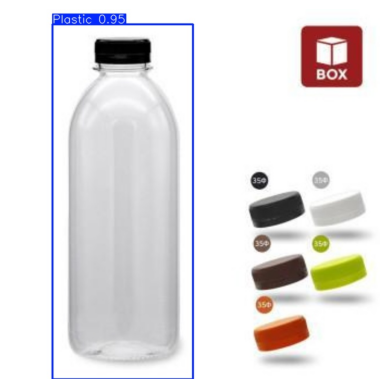

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Affiche une image avec ses annotations prédictives
image_path = "/content/runs/detect/predict/M45.jpg"
img = Image.open(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()


In [15]:
import cv2

# Chemins
input_video_path = "/content/video_test.mp4"
output_video_path = "/content/drive/MyDrive/datadata/test.mp4"

# Charger la vidéo
cap = cv2.VideoCapture(input_video_path)
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec vidéo
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Charger le modèle entraîné
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Traitement frame par frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Appliquer YOLOv8 pour détecter les objets
    results = model.predict(source=frame, save=False, conf=0.5)

    # Vérifier si des boîtes sont détectées
    if len(results[0].boxes) > 0:
        for box in results[0].boxes:
            # Extraire les coordonnées, la confiance et l'ID de classe
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # Coordonnées de la boîte
            confidence = float(box.conf[0])  # Confiance
            class_id = int(box.cls[0])  # ID de classe
            label = f"{model.names[class_id]} {confidence:.2f}"

            # Dessiner les rectangles et ajouter le label
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Enregistrer la frame avec les annotations
    out.write(frame)

# Libérer les ressources
cap.release()
out.release()

print(f"Vidéo avec détections enregistrée à : {output_video_path}")


0: 640x384 (no detections), 69.2ms
Speed: 2.9ms preprocess, 69.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Glass, 60.9ms
Speed: 9.8ms preprocess, 60.9ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Glass, 119.4ms
Speed: 8.2ms preprocess, 119.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Glass, 42.4ms
Speed: 8.6ms preprocess, 42.4ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Glass, 57.6ms
Speed: 5.2ms preprocess, 57.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Plastic, 1 Glass, 83.1ms
Speed: 3.0ms preprocess, 83.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Glass, 47.5ms
Speed: 2.7ms preprocess, 47.5ms inference, 11.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 Plastic, 1 Glass, 36.5ms
Speed: 3.1ms preprocess, 36.5ms inference, 22.8ms postprocess 